### 0. Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import sys
import json
import math
import spacy
import torch
import random
import warnings
import numpy as np
import transformers
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from functools import reduce
from matplotlib import pyplot as plt
nlp = spacy.load("en_core_web_sm")

# import local scripts
sys.path.append('../src/')
from data_loader import DatasetLoader
from alignment_metrics import *
from contrastive_explanations import ContrastiveExplanations
contrastive_explanations = ContrastiveExplanations()

# produce repeatable results
np.random.seed(seed=42)
transformers.set_seed(42)

# enable CUDNN deterministic mode
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# suppress warnings
warnings.filterwarnings('ignore')

### 1. Load the data

In [4]:
def get_data(datasets):
    data_loader = DatasetLoader()

    data = (
        pd.concat(
            [
                pd.DataFrame(data_loader.load_data(dataset_name)["train"])[
                    ["sentence_good", "sentence_bad"]
                ]
                for dataset_name in datasets
            ]
        )
        .reset_index()
        .drop("index", axis=1)
    )

    return data

In [5]:
# displays a phenomenon
data = get_data(["anaphor_gender_agreement"])
data

,sentence_good,sentence_bad
0,Katherine can't help herself.,Katherine can't help himself.
1,Karla could listen to herself.,Karla could listen to himself.
2,Marie won't think about herself.,Marie won't think about itself.
3,Mark hasn't discussed himself.,Mark hasn't discussed itself.
4,Stephen impressed himself.,Stephen impressed itself.
...,...,...
995,Carlos complained about himself.,Carlos complained about itself.
996,Benjamin is firing himself.,Benjamin is firing itself.
997,Chad kisses himself.,Chad kisses herself.
998,Paula was arguing about herself.,Paula was arguing about himself.


### 1. Preprocess data for computing the contrastive explanations

#### 1.1. Define methods for extracting the target for each type of grammatical phenomenon

In [6]:
def extract_reflexive_antecedent(text, target_reflexive):
    # for anaphor agreement

    text += " " + target_reflexive
    doc = nlp(text)

    target_token = None
    for token in doc:
        # reflexive pronouns usually have 'pobj' dependency
        if token.text.lower() == target_reflexive.lower() and token.dep_ in ["pobj", "dobj"]:
            target_token = token
            break

    if not target_token:
        return ""

    for token in target_token.head.lefts:
        if token.dep_ in ["nsubj", "nsubjpass"] and token.pos_ in ["NOUN", "PROPN"]:
            return token.text

    return ""

In [7]:
def get_main_verb(sentence):
    # for argument structure

    doc = nlp(sentence)
    main_verbs = []

    for token in doc:
        if token.pos_ == "VERB":
            main_verbs.append(token.text)

    assert len(main_verbs) == 1

    return main_verbs[0]

In [8]:
def extract_determiner_from_target_noun(text, target_noun):
    # for determiner-noun agreement

    text += " " + target_noun
    doc = nlp(text)

    for token in doc:
        if token.text.lower() == target_noun.lower() and token.pos_ in ["NOUN", "PROPN"]:
            for child in token.children:
                if child.dep_ == "det":
                    return child.text

    return ""


In [9]:
def extract_even(text):
    # for npi licensing
    # even is the first word of all the examples in our dataset

    return text.split(" ")[0]

In [10]:
def get_verb_from_sentence(text):
    doc = nlp(text)
    for token in doc:
        if token.text.lower() and (token.pos_ == "VERB" or token.pos_ == "AUX"):
            return token.text

    return ""

In [11]:
def extract_subject_from_target_verb(text, correct_word):
    # for subject-verb agreement

    text += " " + correct_word
    target_verb = get_verb_from_sentence(text)

    if target_verb == "":
        return target_verb
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == target_verb.lower() and (
            token.pos_ == "VERB" or token.pos_ == "AUX"
        ):
            for child in token.children:
                if child.dep_ in {"nsubj", "nsubjpass"}:
                    return child.text
    return ""


#### 1.2. Define auxiliary data processing operations and the pipeline

In [12]:
def tokenize_sentences(good_sentence, bad_sentence):
    # remove characters that are not letters or apostrophes and replace contractions
    good_sentence_cleaned = re.sub(r"[^\w\s']", "", good_sentence).replace("n't", " not")
    bad_sentence_cleaned = re.sub(r"[^\w\s']", "", bad_sentence).replace("n't", " not")

    # tokenize the text
    good_sentence_tokenized = good_sentence_cleaned.split(" ")
    bad_sentence_tokenized = bad_sentence_cleaned.split(" ")

    return good_sentence_tokenized, bad_sentence_tokenized

In [13]:
def get_common_sentence(good_sentence_tokenized, bad_sentence_tokenized):
    # consider only pairs of sentences with the same number of words
    number_considered_words = min(len(good_sentence_tokenized), len(bad_sentence_tokenized))
    different_lengths = len(good_sentence_tokenized) != len(bad_sentence_tokenized)

    good_sentence_tokenized = good_sentence_tokenized[:number_considered_words]
    bad_sentence_tokenized = bad_sentence_tokenized[:number_considered_words]

    # get the common part of the two sentences (until the first different word)
    same_tokens = np.array(good_sentence_tokenized) == np.array(bad_sentence_tokenized)
    index_first_diff_token = np.where(same_tokens == False)[0][0]

    common_sentence_tokenized = good_sentence_tokenized[:index_first_diff_token]
    common_sentence = " ".join(common_sentence_tokenized)

    return (
        common_sentence,
        common_sentence_tokenized,
        index_first_diff_token,
        different_lengths,
    )

In [14]:
def get_target(phenomenon_type, sentence, correct_word):
    if phenomenon_type == "anaphor agreement":
        return extract_reflexive_antecedent(sentence, correct_word)
    elif phenomenon_type == "argument structure":
        return get_main_verb(sentence)
    elif phenomenon_type == "determiner noun agreement":
        return extract_determiner_from_target_noun(sentence, correct_word)
    elif phenomenon_type == "npi licensing":
        return extract_even(sentence)
    elif phenomenon_type == "subject verb agreement":
        return extract_subject_from_target_verb(sentence, correct_word)

In [15]:
def preprocess_data(input_data, phenomenon_type):
    good_bad_sentences = input_data.to_numpy()
    extracted_sentences_data = []
    dif_lengths_counter = 0

    for good_sentence, bad_sentence in good_bad_sentences:
        good_sentence_tokenized, bad_sentence_tokenized = tokenize_sentences(good_sentence, bad_sentence)
        sentence_info = get_common_sentence(good_sentence_tokenized, bad_sentence_tokenized)
        common_sentence, common_sentence_tokenized, index_first_diff_token, different_lengths = sentence_info

        if different_lengths:
            dif_lengths_counter += 1

        # get the correct and foil words
        correct_word = good_sentence_tokenized[index_first_diff_token]
        foil_word = bad_sentence_tokenized[index_first_diff_token]

        # get the target token
        target = get_target(phenomenon_type, common_sentence, correct_word)

        if target == "":
            continue

        if len(good_sentence_tokenized) -1 == index_first_diff_token:
            is_full_sentence = True
        else:
            is_full_sentence = False

        # construct an array where 1s represent the position of the target word
        known_evidence = np.zeros(len(common_sentence_tokenized))
        evidence_index = np.where(np.array(common_sentence_tokenized) == target)[0][0]
        known_evidence[evidence_index] = 1

        extracted_data = [known_evidence, common_sentence, correct_word, foil_word, is_full_sentence]
        extracted_sentences_data.append(extracted_data)

    return extracted_sentences_data

In [16]:
def preprocess_all_data(phenomenon_names, dataset_names):
    all_extracted_sentences_data = []
    number_of_invalid_examples = []

    for phenomenon_name, dataset_name in zip(phenomenon_names, dataset_names):
        data = get_data([dataset_name])
        extracted_sentences_data = preprocess_data(data, phenomenon_name)
        all_extracted_sentences_data.extend(extracted_sentences_data)
        number_of_invalid_examples.append(data.shape[0] - len(extracted_sentences_data))

    return all_extracted_sentences_data, number_of_invalid_examples

### 2. Compute saliency maps

In [17]:
def match_evidence_with_tokenization(space_tokenization, gpt_tokenization, known_evidence):
    # this function adds 0s or 1s in the known evidence to match the list of GPT tokens

    space_tokenization_index = 0
    updated_known_evidence = []
    accumulated_string = gpt_tokenization[0]

    for gpt_tokenization_index, gpt_token in enumerate(gpt_tokenization[1:]):
        if accumulated_string == space_tokenization[space_tokenization_index]:
            updated_known_evidence.append(known_evidence[space_tokenization_index])
            accumulated_string = gpt_tokenization[gpt_tokenization_index + 1]
            space_tokenization_index += 1

        else:
            accumulated_string += gpt_token
            updated_known_evidence.append(known_evidence[space_tokenization_index])

    updated_known_evidence.append(known_evidence[space_tokenization_index])

    return updated_known_evidence

In [18]:
def compute_alignment_metrics(sentence_data, contrastive_method):
    known_evidence = sentence_data[0]
    sentence = sentence_data[1]
    correct_word = sentence_data[2]
    foil_word = sentence_data[3]

    saliency_map = contrastive_method(sentence, correct_word, foil_word)
    extracted_words = [explanation[0].strip() for explanation in saliency_map]
    explanation = [explanation[1] for explanation in saliency_map]

    if math.isnan(saliency_map[0][1]):
        return None, None, None, None

    known_evidence = match_evidence_with_tokenization(sentence.split(" "), extracted_words, known_evidence)
    mean_dot_product = compute_mean_dot_product([explanation], [known_evidence])
    mean_probes_needed = compute_mean_probes_needed([explanation], [known_evidence])
    mean_reciprocal_rank = compute_mean_reciprocal_rank([explanation], [known_evidence])

    return saliency_map, mean_dot_product, mean_probes_needed, mean_reciprocal_rank

In [19]:
def get_contrastive_method(index, contrastive_explanations):
    if index == 0:
        return "gradient norm", contrastive_explanations.get_contrastive_gradient_norm
    elif index == 1:
        return "input x gradient", contrastive_explanations.get_contrastive_input_x_gradient
    else:
        return "input erasure", contrastive_explanations.get_input_erasure

### 3. Extract data for form

In [20]:
anaphor_agreement_datasets = [
    "anaphor_gender_agreement",
    "anaphor_number_agreement",
]

argument_structure_datasets = ["animate_subject_passive"]

determiner_noun_agreement_datasets = [
    "determiner_noun_agreement_1",
    "determiner_noun_agreement_irregular_1",
    "determiner_noun_agreement_with_adjective_1",
    "determiner_noun_agreement_with_adj_irregular_1",
]

npi_licesing_datasets = [
    "npi_present_1",
]

subject_verb_agreement_datasets = [
    "distractor_agreement_relational_noun",
    "irregular_plural_subject_verb_agreement_1",
    "regular_plural_subject_verb_agreement_1",
]

phenomena = [
    "anaphor agreement",
    "argument structure",
    "determiner noun agreement",
    "npi licensing",
    "subject verb agreement",
]

datasets = [
    anaphor_agreement_datasets,
    argument_structure_datasets,
    determiner_noun_agreement_datasets,
    npi_licesing_datasets,
    subject_verb_agreement_datasets,
]

In [21]:
def extract_form_data(extracted_sentences_data, phenomenon, contrastive_explanations, number_of_examples=8):
    index = 0
    form_data = []
    random.shuffle(extracted_sentences_data)

    for sentence_data in extracted_sentences_data:
        contrastive_function_name, contrastive_function = get_contrastive_method(index, contrastive_explanations)
        saliency_map, _, _, _ = compute_alignment_metrics(sentence_data, contrastive_function)

        if contrastive_function_name is None or saliency_map is None:
            continue

        form_data.append(
            {
                "phenomenon": phenomenon,
                "input sentence": sentence_data[1],
                "correct word": sentence_data[2],
                "wrong word": sentence_data[3],
                "contrastive function": contrastive_function_name,
                "explanation": saliency_map,
            }
        )

        index += 1

        if index == number_of_examples:
            break

    return form_data

In [22]:
global_form_data = []

for phenomenon, datasets_for_phenomenon in zip(phenomena, datasets):
    data = get_data(datasets_for_phenomenon)
    extracted_sentences_data = preprocess_data(data, phenomenon)
    global_form_data += extract_form_data(extracted_sentences_data, phenomenon, contrastive_explanations)

with open('./data/form_data.json', 'w') as f:
    json.dump(global_form_data, f)

### 4. Compute alignment metrics

In [23]:
dataset_names = [
    "anaphor_gender_agreement",
    "anaphor_number_agreement",
    "animate_subject_passive",
    "determiner_noun_agreement_1",
    "determiner_noun_agreement_irregular_1",
    "determiner_noun_agreement_with_adjective_1",
    "determiner_noun_agreement_with_adj_irregular_1",
    "npi_present_1",
    "distractor_agreement_relational_noun",
    "irregular_plural_subject_verb_agreement_1",
    "regular_plural_subject_verb_agreement_1",
]

phenomenon_names = [
    "anaphor agreement",
    "anaphor agreement",
    "argument structure",
    "determiner noun agreement",
    "determiner noun agreement",
    "determiner noun agreement",
    "determiner noun agreement",
    "npi licensing",
    "subject verb agreement",
    "subject verb agreement",
    "subject verb agreement",
]


In [24]:
def get_metric_entire_dataset(all_extracted_sentences_data, contrastive_method, contrastive_method_name):
    explanations = []
    known_evidences = []

    for sentence_data in tqdm(all_extracted_sentences_data):
        known_evidence = sentence_data[0]
        sentence = sentence_data[1]
        correct_word = sentence_data[2]
        foil_word = sentence_data[3]

        saliency_map = contrastive_method(sentence, correct_word, foil_word)
        extracted_words = [explanation[0].strip() for explanation in saliency_map]
        explanation = [explanation[1] for explanation in saliency_map]

        if math.isnan(saliency_map[0][1]):
            continue

        known_evidence = match_evidence_with_tokenization(sentence.split(" "), extracted_words, known_evidence)

        explanations.append(explanation)
        known_evidences.append(known_evidence)

    print(f"Number of sentences considered in the end by {contrastive_method_name}: {len(explanations)}")
    mean_dot_product = compute_mean_dot_product(explanations, known_evidences)
    mean_probes_needed = compute_mean_probes_needed(explanations, known_evidences)
    mean_reciprocal_rank = compute_mean_reciprocal_rank(explanations, known_evidences)

    return mean_dot_product, mean_probes_needed, mean_reciprocal_rank

In [25]:
def get_metrics_entire_dataset(all_extracted_sentences_datam, contrastive_explanations, results_name):
    overall_metrics = {}

    for contrastive_method_index in range(3):
        contrastive_method_name, contrastive_method = get_contrastive_method(contrastive_method_index, contrastive_explanations)
        mean_dot_product, mean_probes_needed, mean_reciprocal_rank = get_metric_entire_dataset(all_extracted_sentences_data, contrastive_method, contrastive_method_name)

        overall_metrics[f"mean dot product - {contrastive_method_name}"] = mean_dot_product
        overall_metrics[f"mean probes needed - {contrastive_method_name}"] = mean_probes_needed
        overall_metrics[f"mean reciprocal rank - {contrastive_method_name}"] = mean_reciprocal_rank

        with open(f'../results/{results_name}.json', 'w') as f:
            json.dump(overall_metrics, f)

    return overall_metrics

#### 4.1. Averaged across the entire dataset

In [26]:
all_extracted_sentences_data, number_of_invalid_examples = preprocess_all_data(phenomenon_names, dataset_names)
print(f"Total number of invalid examples per phenomenon: {number_of_invalid_examples}")
results_name = "averaged_metrics_all_data"
overall_metrics = get_metrics_entire_dataset(all_extracted_sentences_data, contrastive_explanations, results_name)

Total number of invalid examples per phenomenon: [208, 205, 0, 17, 55, 33, 67, 0, 135, 146, 147]


100%|██████████| 9987/9987 [30:17<00:00,  5.50it/s]


Number of sentences considered in the end by gradient norm: 7793


100%|██████████| 9987/9987 [30:28<00:00,  5.46it/s]


Number of sentences considered in the end by input x gradient: 7793


100%|██████████| 9987/9987 [54:04<00:00,  3.08it/s]  


Number of sentences considered in the end by input erasure: 7793


#### 4.2. Averaged per phenomenon

In [27]:
for phenomenon_index in range(len(phenomena)):
    phenomenon_name = phenomena[phenomenon_index]
    print(phenomenon_name)

    datasets_no_per_phenomenon = len(datasets[phenomenon_index])
    phenomenon_list = [phenomenon_name] * datasets_no_per_phenomenon 
    all_extracted_sentences_data, number_of_invalid_examples = preprocess_all_data(phenomenon_list, datasets[phenomenon_index])

    results_name = "averaged_metrics_" + phenomenon_name.replace(" ", "_")
    _ = get_metrics_entire_dataset(all_extracted_sentences_data, contrastive_explanations, results_name)

anaphor agreement


100%|██████████| 1587/1587 [04:28<00:00,  5.90it/s]


Number of sentences considered in the end by gradient norm: 1587


100%|██████████| 1587/1587 [04:36<00:00,  5.75it/s]


Number of sentences considered in the end by input x gradient: 1587


100%|██████████| 1587/1587 [07:28<00:00,  3.54it/s]


Number of sentences considered in the end by input erasure: 1587
argument structure


100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


Number of sentences considered in the end by gradient norm: 1000


100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


Number of sentences considered in the end by input x gradient: 1000


100%|██████████| 1000/1000 [08:27<00:00,  1.97it/s]


Number of sentences considered in the end by input erasure: 1000
determiner noun agreement


100%|██████████| 3828/3828 [11:31<00:00,  5.53it/s]


Number of sentences considered in the end by gradient norm: 2037


100%|██████████| 3828/3828 [11:32<00:00,  5.53it/s]


Number of sentences considered in the end by input x gradient: 2037


100%|██████████| 3828/3828 [25:22<00:00,  2.51it/s]


Number of sentences considered in the end by input erasure: 2037
npi licensing


100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


Number of sentences considered in the end by gradient norm: 1000


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


Number of sentences considered in the end by input x gradient: 1000


100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]


Number of sentences considered in the end by input erasure: 1000
subject verb agreement


100%|██████████| 2572/2572 [07:58<00:00,  5.37it/s]


Number of sentences considered in the end by gradient norm: 2169


100%|██████████| 2572/2572 [07:56<00:00,  5.39it/s]


Number of sentences considered in the end by input x gradient: 2169


100%|██████████| 2572/2572 [09:47<00:00,  4.38it/s]

Number of sentences considered in the end by input erasure: 2169


### 5. Plot explanation (saliency map)

In [88]:
def plot_explanation(words, scores, name="explanation_example"):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(1.2 * len(scores), 0.5)

    rounded_scores = [round(score, 4) for score in scores]
    xticks_positions = np.array(range(len(rounded_scores))) + 0.5

    sns.heatmap(data=np.array([scores]), annot=np.array([words]), fmt="", cmap='coolwarm', cbar=False, ax=ax)
    ax.set_xticks(ticks=xticks_positions, labels=np.array(rounded_scores))
    ax.set_yticks([])

    plt.show()
    fig.savefig(f"../results/{name}.png", bbox_inches='tight') 

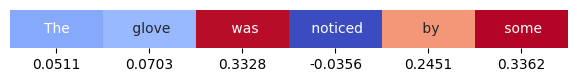

In [89]:
# this is a explanation example
words = [info[0] for info in global_form_data[9]["explanation"]]
scores = [info[1] for info in global_form_data[9]["explanation"]]
plot_explanation(words, scores)